In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import math
import pandas as pd

## define parameters

In [69]:
length = 200. #nondimensional length of window
height = 0.10 #window height
N = 5000 #number of vortices
gammas = 2.9 #vortex strength RMS (normal distribution)
rscale = 0.17 #vortex size scale (rayleigh distribution parameter)
t0 = -1#start time for observation of convection
t1 = 1#end time
ts = 0.0001 # time step
v0 = 100 #convection speed

## set random distribution for vortex location, size and strength
origin at window center

In [70]:
vortx = np.random.uniform(low=-length/2,high=length/2,size=N)
vorty = np.random.uniform(low=-height/2,high=height/2,size=N)
vortX = np.vstack((vortx,vorty))
gamma = np.random.normal(scale=gammas,size=N)
#gamma = np.random.normal(-2,2,N)
print gamma
rho = np.random.rayleigh(scale=rscale,size=N)

[ 3.37701178 -2.08311443  2.9792239  ...  1.34326654  4.92484733
 -5.44067187]


## set relative locations for observation
vortex window moves to the right
t=0 means observation in the center of the window

In [71]:
t = np.arange(t0,t1,ts)
obsx = -v0*t
print obsx
obsy = np.zeros_like(obsx)
obsX = np.vstack((obsx,obsy))

[100.    99.99  99.98 ... -99.97 -99.98 -99.99]


## Vortex models
#### Gaussian shape vortex: $u_\theta = 18\Gamma  \rho^{-3} e^{-9 \rho^{-4} {\boldsymbol{{r}}}^{2}}r$
#### Point vortex (singularity at the center): $u_\theta = \frac{\Gamma}{2 \pi r}$
#### Zero velocity at the absolute center: $u_\theta = \frac{\Gamma r}{2\pi \rho^2}$
#### Combination of point vortex and zero velocity at the center vortex : $minimum of$ $u_\theta = \frac{\Gamma}{2 \pi r}$ $and$ $u_\theta = \frac{\Gamma r}{2\pi \rho^2}$
#### Lamb-Oseen vortex: $u_\theta = \frac{\Gamma}{2{\pi}r}\left ( 1-exp\left ( -\frac{r^2}{\rho^2} \right ) \right )$
#### Mexican-Hat shape vortex: $u_\theta = 16 \Gamma r \rho^{-3}exp\left ( -\left ( \sqrt{8}\rho^{-2}r \right )^{2} \right )\left ( 3-\left ( 4\rho^{-2}r \right )^{2} \right )$

In [83]:
dist = obsX[:,:,np.newaxis]-vortX[:,np.newaxis,:] # dim 2 x timesteps x N
r = np.sqrt((dist*dist).sum(0)) # dim timesteps x N

'''comment out one of the two following lines to get alternative vortex models:'''

utheta1 = 18 * gamma * (rho**(-3)) * np.exp((-9*r**2) / (rho**4)) * r   # Gaussian shape function vortex

#utheta = (0.5/np.pi)*(1/r)                                             # Point vortex with singularity at the center

#utheta = (0.5/np.pi)*gamma*np.minimum(1/r,r/rho)                       # Wrong because r/rho is dimensionaless :dim timesteps x N:

#utheta = (0.5/np.pi)*gamma*np.minimum(1/r,r/rho**2)                    # Gaussian shape 2

#utheta = (0.5/np.pi)*gamma/r/r                                         # Wrong because it's divinding the function twice by 'r'

#utheta = gamma*rho**(1.5)*np.exp(-9*rho*rho*r*r)                       # Wrong

#utheta = (0.5/np.pi)*(1/r)*(1-np.exp(-(r**2)/rho**2))                  # Lamb-Oseen vortex

utheta2 = 16 * gamma * (rho**(-3)) * np.exp(-8*(rho**(-4)) * r**2) * (3-(16 * (rho**(-4)) * r**2)) * r  # Mexican-hat shape

# into cartesian coords

uind1 = utheta1 * dist[::-1] # dim 2 x timesteps x N
uind1[0] *= -1 # change sign for ux (to get correct rotation)
# sum over vortices
utot1 = uind1.sum(2) # dim 2 x timesteps

uind2 = utheta2 * dist[::-1] # dim 2 x timesteps x N
uind2[0] *= -1 # change sign for ux (to get correct rotation)
# sum over vortices
utot2 = uind2.sum(2) # dim 2 x timesteps

## Plot time histories and psd for induced velocity and comparing it with von Kárman velocity spectra

<IPython.core.display.Javascript object>


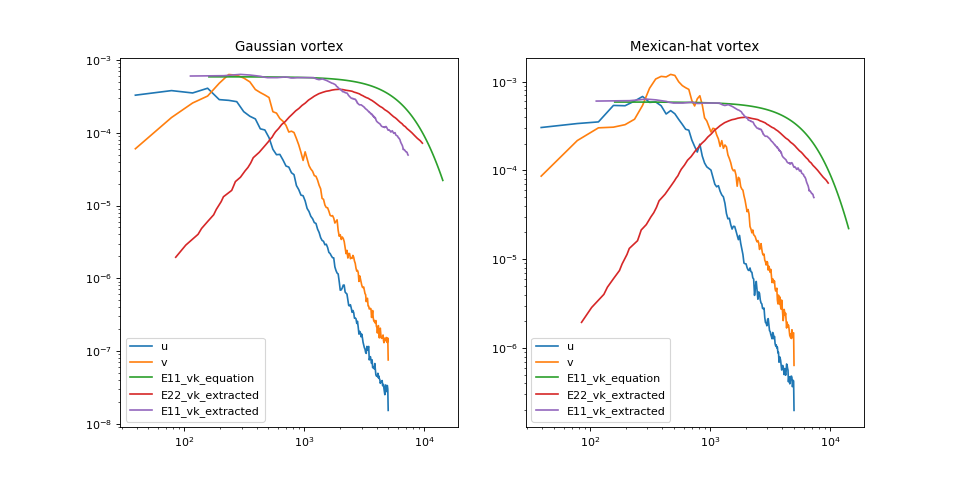

In [105]:
M = 0.3 # Mach number
a = 340 # speed of sound
Tu = 0.017 # Turbulent Intensity
U = M * a
Urms = Tu * U
Lt = 0.008 # Length scale normalised to chord length (c=1; Lt/Lc=0.04)

#Mathematical formulation for E11 (Ref. Ewert 2015, Diester & Gabard 2010)
Lo = Lt * math.gamma(0.33) / (math.gamma(0.5) * math.gamma(0.833))
f = []
E1 = []
for i in range(1, 90, 1): # range is given in wavenumbers
    f.append(i*(U/2*np.pi))
    E1.append(((Urms**2 * Lt)/(np.pi * (1 + ((Lo**2)*(i**2)))**5/6))*(1./2.4)*np.pi/U) 

#Plotting E22 and E11 which are extracted from a plot (Ref. Gea-Augilera 2017)     
filename = 'E22_vk.csv'
filename1 = 'E11vk.csv'
frequenz = pd.read_csv(filename, header=None, usecols=[0])
E22 = pd.read_csv(filename, header=None, usecols=[1])
E22 = (10**E22)**0.1
frequenz1 = pd.read_csv(filename1, header=None, usecols=[0])
E11 = pd.read_csv(filename1, header=None, usecols=[1])
E11 = (10**E11)**0.1
'''
plt.figure(2)
plt.subplot(1,2,1)
plt.plot(t,utot[0],label='u')
plt.plot(t,utot[1],label='v')
plt.legend()
plt.subplot(1,2,2)
(valu,freq) = psd(utot1[0],Fs=1/ts,detrend='mean')
(valv,freq) = psd(utot1[1],Fs=1/ts,detrend='mean')
plt.loglog(freq[1:],valu[1:],label='u')
plt.loglog(freq[1:],valv[1:],label='v')
#plt.loglog(freq[1:],valu[1:]+valv[1:],label='tot')
plt.loglog(f,E1,label='E11_vk_equation')
plt.loglog(frequenz, E22,label='E22_vk_extracted')
plt.loglog(frequenz1, E11,label='E11_vk_extracted')
plt.legend()
#plt.savefig('spectra1.pdf')
'''
plt.figure(1,figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('Gaussian vortex')
(valu,freq) = psd(utot1[0],Fs=1/ts,detrend='mean')
(valv,freq) = psd(utot1[1],Fs=1/ts,detrend='mean')
plt.loglog(freq[1:],valu[1:],label='u')
plt.loglog(freq[1:],valv[1:],label='v')
plt.loglog(f,E1,label='E11_vk_equation')
plt.loglog(frequenz, E22,label='E22_vk_extracted')
plt.loglog(frequenz1, E11,label='E11_vk_extracted')
plt.legend(loc=3)
plt.subplot(1,2,2)
plt.title('Mexican-hat vortex')
(valu,freq) = psd(utot2[0],Fs=1/ts,detrend='mean')
(valv,freq) = psd(utot2[1],Fs=1/ts,detrend='mean')
plt.loglog(freq[1:],valu[1:],label='u')
plt.loglog(freq[1:],valv[1:],label='v')
plt.loglog(f,E1,label='E11_vk_equation')
plt.loglog(frequenz, E22,label='E22_vk_extracted')
plt.loglog(frequenz1, E11,label='E11_vk_extracted')
plt.legend(loc=3)
plt.savefig('spectra_GMH.pdf')